In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'dpi':200, 'bbox_inches': 'tight'}
from matplotlib_latex_configurations import *
rcParams['figure.figsize'] = (one_column_figure_size * golden_ration, one_column_figure_size)

import numpy as np
import os as os
import geocluster as gc
from geocluster import plotting
from graph_library import generate_GN, assign_graph_metadata
import networkx as nx
import scipy as sc
import pylab as plt
from tqdm import tqdm
import networkx as nx

# SBM diffusion and curvature

Dense

In [2]:
n=100
p_in = 0.5
p_out = 0.1

graph, _ = generate_GN({'l': 2, 'g': int(n/2), 'p_in': p_in, 'p_out': p_out}, seed=1)
pos_dense = nx.spring_layout(graph, weight='weight')
graph_dense = assign_graph_metadata(graph, pos=pos_dense)
times = np.logspace(-2, 2., 25)
kappa_dense = gc.compute_curvatures(graph, times,use_spectral_gap=False)

#find the node sourcenode corresponding to the min curvature edge
edgeid = np.unravel_index(kappa_dense.argmin(), kappa_dense.shape)[1]
minedge = list(graph_dense.edges)[edgeid]
source_dense = minedge[0]

100%|██████████| 25/25 [00:22<00:00,  1.11it/s]


Sparse

In [3]:
n=100
p_in = 8/n
p_out = 0.5/n

graph, _ = generate_GN({'l': 2, 'g': int(n/2), 'p_in': p_in, 'p_out': p_out}, seed=1)
pos_sparse = nx.spring_layout(graph, weight='weight')
graph_sparse = assign_graph_metadata(graph, pos=pos_sparse)
times = np.logspace(-2, 2., 25)
kappa_sparse = gc.compute_curvatures(graph, times,use_spectral_gap=False)

#find the node source node corresponding to the min curvature edge
edgeid = np.unravel_index(kappa_sparse.argmin(), kappa_sparse.shape)[1]
minedge = list(graph_sparse.edges)[edgeid]
source_sparse = minedge[0]

100%|██████████| 25/25 [00:05<00:00,  4.84it/s]


Null model

In [4]:
graph, _ = generate_GN({'l': 2, 'g': int(n/2), 'p_in': (p_in+p_out)/2, 'p_out': (p_in+p_out)/2}, seed=0)
pos_null = nx.spring_layout(graph, weight='weight')
graph_null = assign_graph_metadata(graph, pos=pos_null)
kappa_null = gc.compute_curvatures(graph_null, times,use_spectral_gap=False)

100%|██████████| 25/25 [00:05<00:00,  4.67it/s]


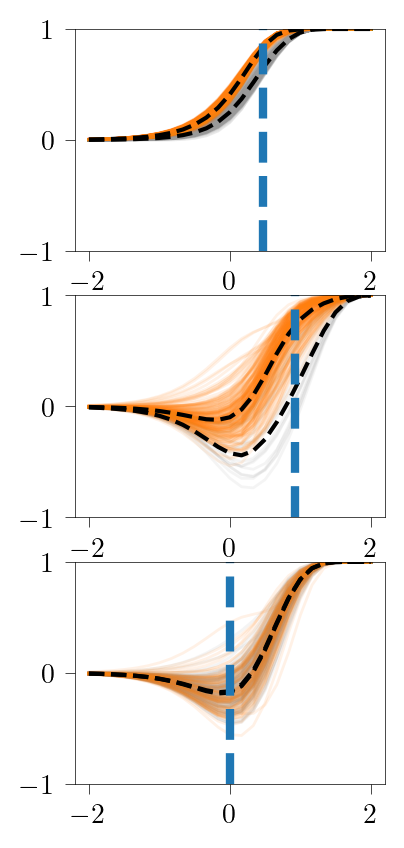

In [20]:
def plot_curvatures(graph, kappa, ax, lambdac):
    kappa_within = []
    kappa_between = []
    for i, e in enumerate(graph.edges):
        if e[0]<n/2 and e[1]>=n/2:
            kappa_between.append(kappa[:,i])
            ax.plot(np.log10(times), kappa[:,i],color=(0.6,0.6,0.6),alpha=0.1, linewidth=1)
        else:
            kappa_within.append(kappa[:,i])
            ax.plot(np.log10(times), kappa[:,i],'C1',alpha=0.1, linewidth=1)
        
    kappa_within_mean = np.mean(kappa_within, axis=0)
    kappa_between_mean = np.mean(kappa_between, axis=0)  
    kappa_within_std = np.max(np.std(kappa_within, axis=0))
    kappa_between_std = np.max(np.std(kappa_between, axis=0))

    ax.plot(np.log10(times),kappa_within_mean, '--', color='k')
    ax.plot(np.log10(times),kappa_between_mean, '--', color='k')
    ax.axvline(np.log10(1/lambdac), c='C0',lw=3,ls='--')
    ax.set_ylim([-1,1])
    
    return np.abs(kappa_within_mean - kappa_between_mean)/np.sqrt((kappa_within_std**2 + kappa_between_std**2)/2)

plt.figure(figsize=(2,5))
    
ax1 = plt.subplot(311)

separation_dense = plot_curvatures(graph_dense, kappa_dense, ax1, 2*0.1/(0.1+0.5))

ax2 = plt.subplot(312)

separation_sparse = plot_curvatures(graph_sparse, kappa_sparse, ax2, 2*0.5/(0.5+8))

ax3 = plt.subplot(313)

separation_null = plot_curvatures(graph_null, kappa_null, ax3, 1)
    
#plt.savefig('sbm_sparse_1.svg')

Test for bimodality

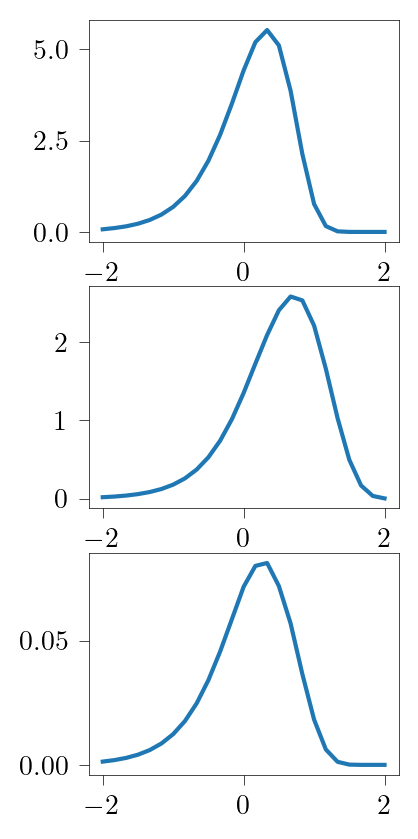

In [21]:
plt.figure(figsize=(2,5))
ax1 = plt.subplot(311)
ax1.plot(np.log10(times),separation_dense)

ax2 = plt.subplot(312)
ax2.plot(np.log10(times),separation_sparse)

ax3 = plt.subplot(313)
ax3.plot(np.log10(times),separation_null)

plt.savefig('kappa_separation.svg')

Diffusions

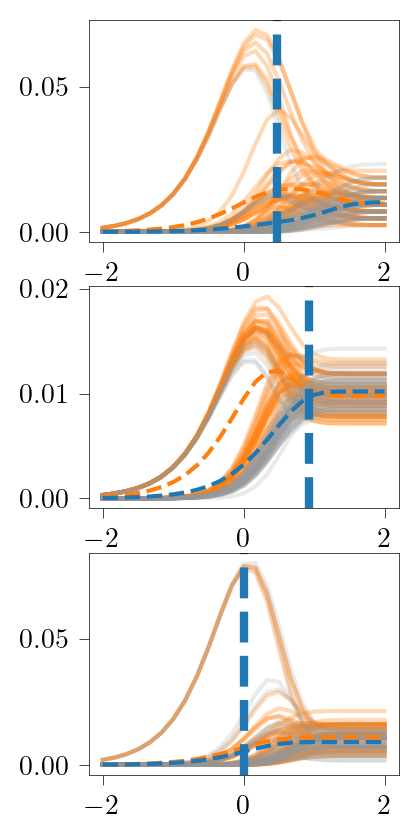

In [88]:
# compute all neighbourhood densities
def mx_comp(graph, T, i):
    
    degrees = np.array([graph.degree[i] for i in graph.nodes])
    L = nx.laplacian_matrix(graph).dot(sc.sparse.diags(1.0 / degrees))
    N = len(graph.nodes)

    def delta(i, n):
        p0 = np.zeros(n)
        p0[i] = 1.
        return p0

    mx_all = [] 
    mx_tmp = delta(i, N) #set initial condition
    T = [0,] + list(T) #add time 0
    
    for i in range(len((T))-1): 
        #compute exponential by increments (faster than from 0)
        mx_tmp = sc.sparse.linalg.expm_multiply(-(T[i+1]-T[i])*L, mx_tmp)
        mx_all.append(mx_tmp)

    return np.array(mx_all)


def plot_densities(graph, times, source, ax, lambda2):
    #compute the densities
    m = mx_comp(graph, times, source)
    
    mask = np.ones(n, dtype=bool)
    mask[source] = 0
    mx = m[:,mask]
    
    ax.plot(np.log10(times), mx[:,:int(n/2)-1], color='C1', alpha=0.3)
    ax.plot(np.log10(times), mx[:,int(n/2):], color=(0.6,0.6,0.6), alpha=0.2)
    ax.plot(np.log10(times), np.mean(mx[:,:int(n/2)-1],axis=1), 'C1--')
    ax.plot(np.log10(times), np.mean(mx[:,int(n/2):],axis=1), 'C0--')
    ax.axvline(np.log10(1/lambda2), c='C0',lw=3,ls='--')

    
plt.figure(figsize=(2,5))
ax1 = plt.subplot(311)

plot_densities(graph_sparse, times, source_sparse, ax1, 2*0.1/(0.1+0.5))

ax2 = plt.subplot(312)

plot_densities(graph_dense, times, source_dense, ax2, 2*0.5/(0.5+8))

ax3 = plt.subplot(313)

plot_densities(graph_null, times, source_dense, ax3, 1)

plt.savefig('sbm_os.svg')

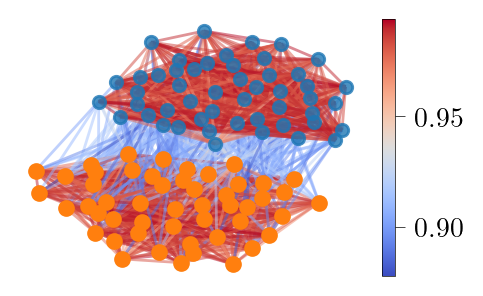

In [86]:
k = kappa_dense[17]

plotting.plot_graph(
    graph_dense,
    edge_color=k,
    node_size=20,
    edge_width=1
)
    
nodes = nx.draw_networkx_nodes(graph_dense, pos = pos_dense, nodelist=[i for i in range(n//2)], node_size = 25, node_color = 'C1')

#nodes = nx.draw_networkx_nodes(graph, pos = pos, nodelist=[source], node_size = 100, node_color = 'g')
#nodes = nx.draw_networkx_nodes(graph, pos = pos, nodelist=[0], node_size = 100, node_color = 'r')
#nodes = nx.draw_networkx_nodes(graph, pos = pos, nodelist=[n-1], node_size = 100, node_color = 'b')

plt.savefig('sbm_dense.svg')

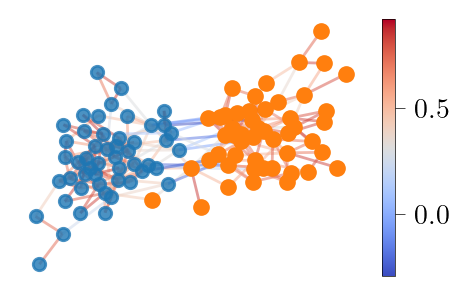

In [87]:
k = kappa_sparse[17]

plotting.plot_graph(
    graph_sparse,
    edge_color=k,
    node_size=20,
    edge_width=1
)
    
nodes = nx.draw_networkx_nodes(graph_sparse, pos = pos_sparse, nodelist=[i for i in range(n//2)], node_size = 25, node_color = 'C1')

plt.savefig('sbm_sparse.svg')

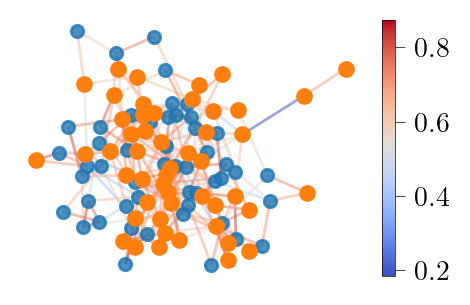

In [93]:
k = kappa_null[17]

plotting.plot_graph(
    graph_null,
    edge_color=k,
    node_size=20,
    edge_width=1
)
    
nodes = nx.draw_networkx_nodes(graph_null, pos = pos_null, nodelist=[i for i in range(n//2)], node_size = 25, node_color = 'C1')

plt.savefig('sbm_null.svg')